<a href="https://colab.research.google.com/github/tuanymariiah/IsuranceAll/blob/main/Health_Insurance_Cross_Sell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalação das Bibliotecas

In [1]:
!pip install psycopg2-binary
!pip install scikit-plot

# Importação das Bibliotecas

In [2]:
#importacao das bibliotecas a serem utilizadas  
import numpy             as np
import pandas            as pd
import psycopg2          as pg
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb
import pandas.io.sql     as psql
import scikitplot        as skplt

import warnings
import tabulate
import random
import pickle
import flask

from sklearn.ensemble     import RandomForestClassifier
from sklearn.naive_bayes  import GaussianNB
from scipy   import stats

from sklearn import preprocessing   as pp
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn import linear_model    as lm
from sklearn import metrics         as m
from scipy   import stats           as ss

#Funções

In [3]:
def precision_at_k(data, y, pred, k=20000):
    

    data['response'] = y.copy()
    data['score'] = pred[:, 1].tolist()
    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)
    data = data.reset_index(drop=True)
    # create ranking order
    data['ranking'] = data.index + 1
    # precision
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']
                            
    return data.loc[k, 'precision_at_k']


def recall_at_k(data, y, pred, k=20000):
    

    data['response'] = y.copy()
    data['score'] = pred[:, 1].tolist()
    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)
    data = data.reset_index(drop=True)
    # create ranking order
    data['ranking'] = data.index + 1
    # recall
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()
                            
    return data.loc[k, 'recall_at_k']


def metrics_at_k(data, y, pred, model_name, k=20000):
         
    data['response'] = y.copy()
    data['score'] = pred[:, 1].tolist()
    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)
    data = data.reset_index(drop=True)
    # create ranking order
    data['ranking'] = data.index + 1

    # precision
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']
    # recall
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()
                            
    return pd.DataFrame({'Precision_at_k':data.loc[k, 'precision_at_k'],
                        'Recall_at_k':data.loc[k, 'recall_at_k']}, index=[model_name])


def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def cross_validation(kfold, modelName, model, data, at_k):
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    recall_list = []
    cv_performance = {}
    
    for train_cv,val_cv in fold.split(data, data['response']):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = data.iloc[train_cv]
        x_train_fold = x_train_fold[cols_selected]
        
        y_train_fold = data['response'].iloc[train_cv]
        
        # validation data
        x_val_fold = data.iloc[val_cv]
        x_val_fold = x_val_fold[cols_selected]
        
        y_val_fold = data['response'].iloc[val_cv]
        
        # fitting the model
        model_fitted = model.fit(x_train_fold,y_train_fold)
        
        # getting the prediction probability
        x_val_fold['response'] = y_val_fold
        val_scored = prediction_score(model_fitted, x_val_fold)
        
        # Getting precision and recall at k
        precision = val_scored.loc[at_k, 'precision_at_k']
        recall = val_scored.loc[at_k, 'recall_at_k']
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    # calculating the mean and std performance of all kfolds
    precision_cv = np.round(np.mean(precision_list),4).astype(float)
    std_precision_cv = '+/-' + np.round(np.std(precision_list),4).astype(str)
    recall_cv = np.round(np.mean(recall_list),4).astype(float)
    std_recall_cv = ' +/- ' + np.round(np.std(recall_list),4).astype(str)
        
    cv_performance[modelName] = [precision_cv, std_precision_cv, recall_cv, std_recall_cv]
    model_performance_cv = pd.DataFrame(cv_performance, index=['precision_at_k', 'std_precision', 'recall_at_k', 'std_recall'])

    return model_performance_cv
def frequency_encoding(df, column):
    encoder = df.groupby(column).size()/len(df)
    return encoder

def prediction_score(model, data):
    # Separating train and validation dataset for each kfold
    x_train = data.drop(columns=['response'])
    y_train = data['response']
    
    # prediction probability (score)
    yhat_proba = model.predict_proba(x_train)[:, 1].tolist()
    
    # merging score to dataset
    data_scored = data.copy()
    data_scored['score'] = yhat_proba
    
    # sort
    data_scored = data_scored.sort_values('score', ascending=False)
    
    # precision and recall
    data_scored = data_scored.reset_index(drop=True)
    data_scored['n_samples'] = data_scored.index + 1
    data_scored['precision_at_k'] = data_scored['response'].cumsum() / data_scored['n_samples']
    data_scored['recall_at_k'] = data_scored['response'].cumsum() / data_scored['response'].sum()
    
    return data_scored


# Carrega dados direto da AWS com pandas

In [4]:
'''
host =  'XXXXXX'
port = 5432
database = 'XXXXXX' 
pwd = 'XXXXXX'
username = 'XXXXXX'
conn = pg.connect(user = username,
                  password = pwd,
                  host = host,
                  port = port,
                  database = database)

query = 'SELECT * FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id) LEFT JOIN PA004.insurance i ON (u.id = i.id) WHERE U.age > 44'
df = pd.read_sql(query, conn)
'''

"\nhost =  'XXXXXX'\nport = 5432\ndatabase = 'XXXXXX' \npwd = 'XXXXXX'\nusername = 'XXXXXX'\nconn = pg.connect(user = username,\n                  password = pwd,\n                  host = host,\n                  port = port,\n                  database = database)\n\nquery = 'SELECT * FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id) LEFT JOIN PA004.insurance i ON (u.id = i.id) WHERE U.age > 44'\ndf = pd.read_sql(query, conn)\n"

In [5]:
#df = df.loc[:,~df.columns.duplicated()] #retira as colunas duplicadas


#Salva os dados para serem usados posteriormente

In [6]:
#df.to_csv('/content/drive/MyDrive/Projetos Pessoais/comunidade ds/[PA004]/dataset/train2.csv', index=False)

#Carrega os dados direto do pandas

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Projetos Pessoais/comunidade ds/[PA004]/dataset/train2.csv')

# Data Description

In [8]:
df1 = df.copy()
new_cols = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']
df1.columns = new_cols

## Data dimension

In [9]:
print(f'Number of Rows {df1.shape[0]}\nNumber of cols {df1.shape[1]}')

Number of Rows 131948
Number of cols 12


## Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license         float64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium            int64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## Features Description

1. **id**: Customer identifier
2. **gender**: Gender of customer
3. **age**: Age of customer
4. **region_code**: Region code of customer
5. **policy_sales_channel**: anonymous code for contact with customer.
6. **previously_insured**: 0 if customer does not have a vehicle insurance; 1 if customer already has a vehicle insurance.
7. **annual_premium**: amount paid for health insurance to the company anualy.
8. **vintage**: time (in days) that customer bought his health assurance.
9. **driving_license**: 0 if customer does not have the permission for drive; 1 if customer has the permission for driveRegion
10. **vehicle_age**: Age of vehicle
11. **vehicle_damage**: 0 if customer never got involved in a previous vehicle * damage; 1 if customer already had a vehicle damage
12 **response**: 0 if customer has no interest in product; 1 if customer has interest in product

## Data Descriptive


In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,2.0,381109.0,381107.0,190677.571816,190690.5,110092.779601,-0.000368,-1.201831
1,age,45.0,85.0,40.0,56.939635,55.0,9.469115,0.640036,-0.649460
2,driving_license,0.0,52.0,52.0,26.985388,28.0,12.310347,-0.209233,-0.407361
3,region_code,1.0,163.0,162.0,74.217237,30.0,53.440006,0.200884,-1.768637
4,previously_insured,0.0,1.0,1.0,0.994096,1.0,0.076609,-12.899263,164.393472
5,annual_premium,0.0,1.0,1.0,0.313427,0.0,0.463886,0.804403,-1.352957
6,policy_sales_channel,2630.0,540165.0,537535.0,32301.524040,34034.5,19160.604775,1.920845,36.133813
7,vintage,10.0,299.0,289.0,154.276010,154.0,83.644379,0.001730,-1.201913
8,response,0.0,1.0,1.0,0.159517,0.0,0.366158,1.859780,1.458803


# Feature Engineering


In [13]:
# vehicle age
df1['vehicle_age'] =  df1['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' ) 


#vehicle_damage
def muda_yesno(registro):
  if registro['vehicle_damage'] == 'Yes':
    return '1'
  elif registro['vehicle_damage'] == 'No':
    return '0'
df1['vehicle_damage'] = df1.apply(muda_yesno, axis=1)

# EDA

In [14]:
df4 = df1.copy()


## Univariate Analisys


### AGE
Pelo gráfico apresentado abaixo, podemos ver que pessoas mais jovens entre 25 a 30 anos, aproximadamente **NÃO** tem interesse em seguro.
Já pessoas um pouco mais velha possui um interesse maior.

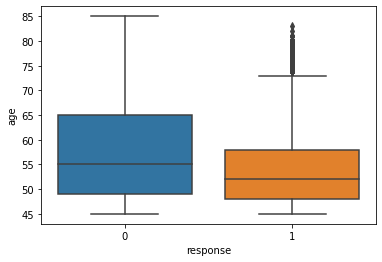

In [15]:
sns.boxplot(x='response', y='age', data = df4);

de acordo com o histograma apresentado abaixo, é possivel ver que realmente pessoas que tem entre 20 a 35 anos nao tem interesse em ter um seguro e que pessoas acima dessa idade sim.

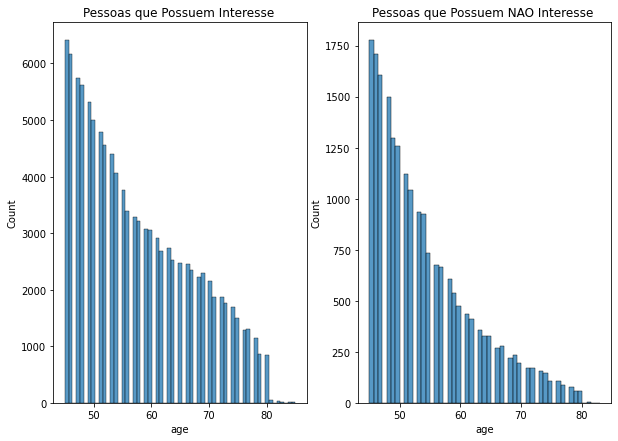

In [16]:
aux00 = df4.loc[df4['response'] == 0, 'age']
aux01 = df4.loc[df4['response'] == 1, 'age']
plt.figure(figsize=(10,7))

ax = plt.subplot(1,2,1);
plt.title('Pessoas que Possuem Interesse ')
sns.histplot(aux00);

ax = plt.subplot(1,2,2);
plt.title('Pessoas que Possuem NAO Interesse ')
sns.histplot(aux01);

### Annual Premium

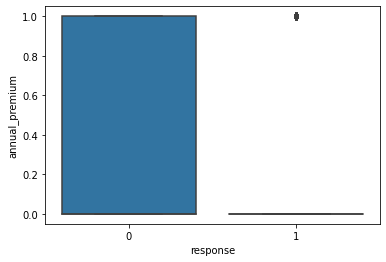

In [17]:
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux )

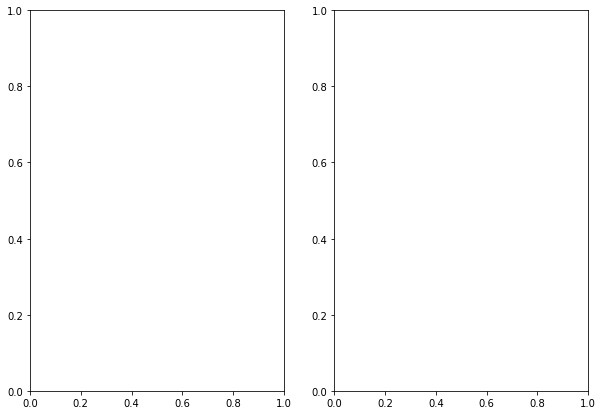

In [18]:
aux = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 80000 )]
aux01 = aux.loc[aux['response'] == 0, 'annual_premium']
aux02 = aux.loc[aux['response'] == 1, 'annual_premium']
plt.figure(figsize=(10,7))

ax = plt.subplot(1,2,1);
sns.histplot( aux01 );

ax = plt.subplot(1,2,2);
sns.histplot( aux02 );

### Driving License

Como podemos ver 87% das pessoas que nao dirigem possuem licensa para dirigir, mas isso pode ter algo em comum com a idade dessas pessos, pois como já vimos, pessoas que mais jovens nao tem interesse eem ter um seguro

In [19]:
aux003 = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux003.head()
aux003['driving_license_perc'] = aux003['driving_license'] / aux003['driving_license'].sum()
aux003

,response,driving_license,driving_license_perc
0,0,2994055.0,0.840869
1,1,566613.0,0.159131


### Region

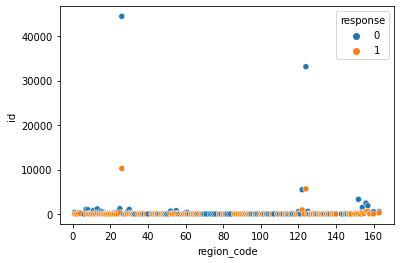

In [20]:
aux004 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()

sns.scatterplot( x='region_code', y='id', hue='response', data=aux004 );

### Previously Insured

In [21]:
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 ) 

response,0,1
previously_insured,,
0,0.949936,0.050064
1,0.839833,0.160167


### Vehicle Age

In [22]:
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index() 

,vehicle_age,response,0
0,between_1_2_year,0,0.766643
1,between_1_2_year,1,0.130385
2,over_2_years,0,0.070869
3,over_2_years,1,0.028428
4,below_1_year,0,0.002971
5,below_1_year,1,0.000705


### Policy Sales Channel

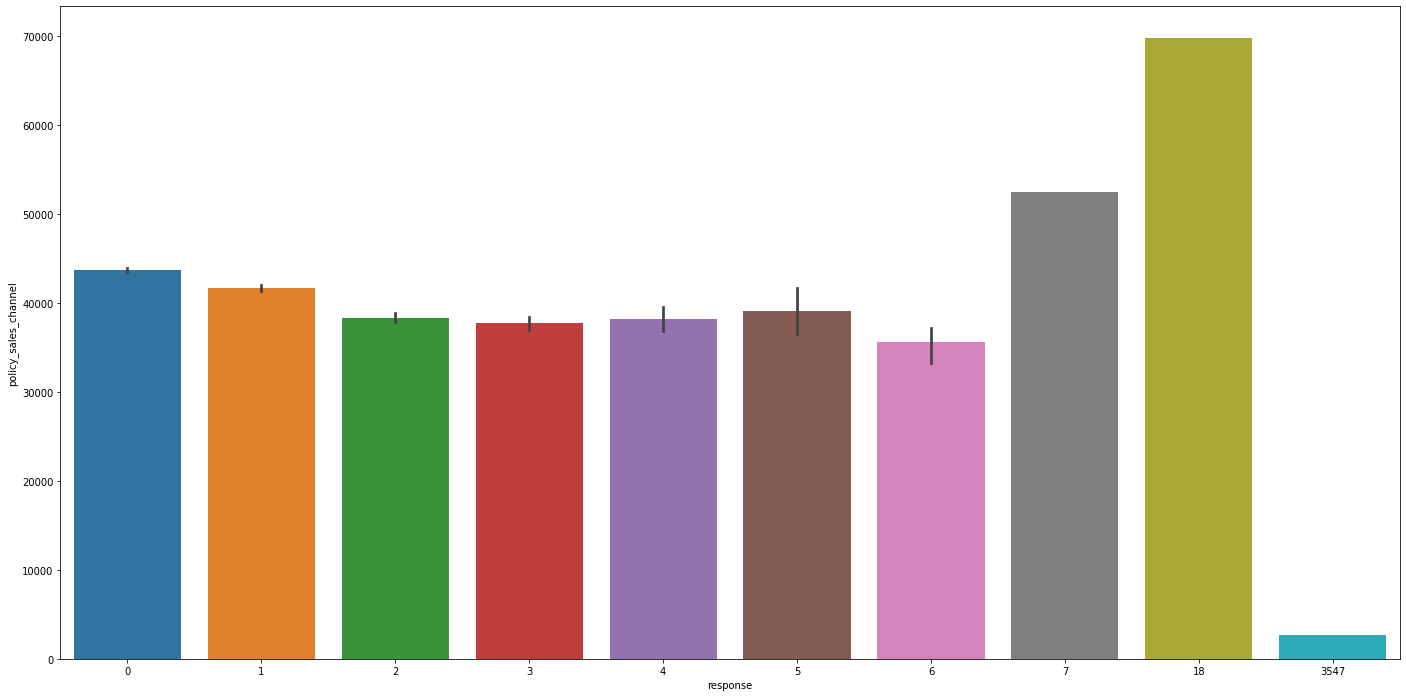

In [23]:
plt.figure( figsize=(24, 12 ))
aux005 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux005 );

### Vintage

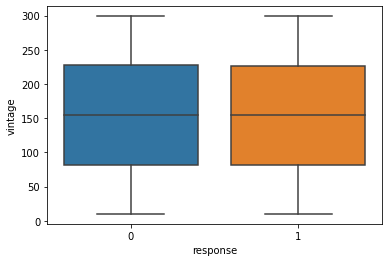

In [24]:
sns.boxplot( x='response', y='vintage', data=df4 );

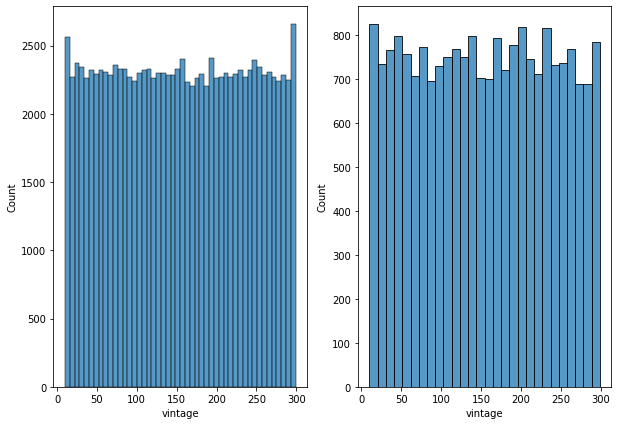

In [25]:
aux006 = df4.loc[df4['response'] == 0, 'vintage']
aux007 = df4.loc[df4['response'] == 1, 'vintage']

plt.figure(figsize=(10,7))

ax = plt.subplot(1,2,1);
sns.histplot( aux006 )

ax = plt.subplot(1,2,2);
sns.histplot( aux007 );

#Data Preparation

In [26]:
df5 = df4.copy() 

In [27]:
# Spliting Data into Train and Validation
X = df5.drop('response', axis=1)
y = df5['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.25, random_state=2)

df5 = pd.concat([x_train, y_train], axis=1)

## Standardization


In [28]:
# annual_premium
ss = pp.StandardScaler()

df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
##pickle.dump(ss, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/annual_premium_scaler.pkl', 'wb'))

## Rescaling

In [29]:
# age
mms_age = pp.MinMaxScaler()
df5['age'] = mms_age.fit_transform(df5[['age']].values)
#pickle.dump(mms_age, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/age_scaler.pkl', 'wb'))
 
# vintage
mms_vintage = pp.MinMaxScaler()
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
#pickle.dump(mms_vintage, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/vintage_scaler.pkl', 'wb'))


## Frequency Encoder

In [30]:
# policy_sales_channel - **Frequency Encoding**
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
#pickle.dump(fe_policy_sales_channel, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/policy_sales_channel_scaler.pkl', 'wb'))



## Encoder

In [31]:
# gender - **One Hot Encoding**
ohc_gender = pp.OneHotEncoder()
df5['gender_Female'] = ohc_gender.fit_transform(df5[['gender']]).toarray()[:,0]
df5['gender_Male'] = ohc_gender.fit_transform(df5[['gender']]).toarray()[:,1]
df5.drop(columns='gender', inplace=True)
#pickle.dump(ohc_gender, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/ohc_gender_scaler.pkl', 'wb'))

# vehicle_age - **One Hot Encoding**
ohc_vehicle_age = pp.OneHotEncoder()
df5['vehicle_age_1-2 Year'] = ohc_vehicle_age.fit_transform(df5[['vehicle_age']]).toarray()[:,0]
df5['vehicle_age_< 1 Year'] = ohc_vehicle_age.fit_transform(df5[['vehicle_age']]).toarray()[:,1]
df5['vehicle_age_> 2 Years'] = ohc_vehicle_age.fit_transform(df5[['vehicle_age']]).toarray()[:,2]
df5.drop(columns='vehicle_age', inplace=True)
#pickle.dump(ohc_vehicle_age, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/ohc_vehicle_age_scaler.pkl', 'wb'))

# vehicle_damage **One Hot Encoding**
ohc_vehicle_damage = pp.OneHotEncoder()
df5['vehicle_damage_No'] = ohc_vehicle_damage.fit_transform(df5[['vehicle_damage']]).toarray()[:,0]
df5['vehicle_damage_Yes'] = ohc_vehicle_damage.fit_transform(df5[['vehicle_damage']]).toarray()[:,1]
df5.drop(columns='vehicle_damage', inplace=True)
#pickle.dump(ohc_vehicle_damage, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/ohc_vehicle_damage_scaler.pkl', 'wb'))

# region_code - **Target Encoding**
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(target_encode_region_code)
#pickle.dump(target_encode_region_code, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/region_code_scaler.pkl', 'wb'))

## Validation Preparation

In [32]:
# annual_premium
x_validation['annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# age
x_validation['age'] = mms_age.transform(x_validation[['age']].values)

# vintage
x_validation['vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# gender - **One Hot Encoding**
x_validation['gender_Female'] = ohc_gender.transform(x_validation[['gender']]).toarray()[:,0]
x_validation['gender_Male'] = ohc_gender.transform(x_validation[['gender']]).toarray()[:,1]
x_validation.drop(columns='gender', inplace=True)

# driving_license - already encoded (0 /1)

# region_code - Frequency Encoding or **Target Encoding**
x_validation['region_code'] = x_validation['region_code'].map(target_encode_region_code)

# # previously_insured - already encoded (0 /1)

# vehicle_age - **One Hot Encoding** / Frequency Encoding / Order Encoding
x_validation['vehicle_age_1-2 Year'] = ohc_vehicle_age.transform(x_validation[['vehicle_age']]).toarray()[:,0]
x_validation['vehicle_age_< 1 Year'] = ohc_vehicle_age.transform(x_validation[['vehicle_age']]).toarray()[:,1]
x_validation['vehicle_age_> 2 Years'] = ohc_vehicle_age.transform(x_validation[['vehicle_age']]).toarray()[:,2]
x_validation.drop(columns='vehicle_age', inplace=True)

# vehicle_damage **One Hot Encoding** / Frequency Encoding / Order Encoding
x_validation['vehicle_damage_No'] = ohc_vehicle_damage.transform(x_validation[['vehicle_damage']]).toarray()[:,0]
x_validation['vehicle_damage_Yes'] = ohc_vehicle_damage.transform(x_validation[['vehicle_damage']]).toarray()[:,1]
x_validation.drop(columns='vehicle_damage', inplace=True)


# policy_sales_channel - Target Encoding / **Frequency Encoding**
x_validation['policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)
x_validation['policy_sales_channel'].fillna(df5['policy_sales_channel'].min(), inplace=True)

x_validation = x_validation.fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

## Feature Selection

In [33]:
df6 = df5.copy()

Feature ranking:
                 feature  importance
0                vintage    0.382573
0                    age    0.155855
0        driving_license    0.121492
0   policy_sales_channel    0.117927
0            region_code    0.110736
0      vehicle_damage_No    0.038762
0     vehicle_damage_Yes    0.033419
0         annual_premium    0.029357
0  vehicle_age_> 2 Years    0.003443
0   vehicle_age_< 1 Year    0.003278
0            gender_Male    0.000977
0          gender_Female    0.000892
0     previously_insured    0.000851
0   vehicle_age_1-2 Year    0.000440


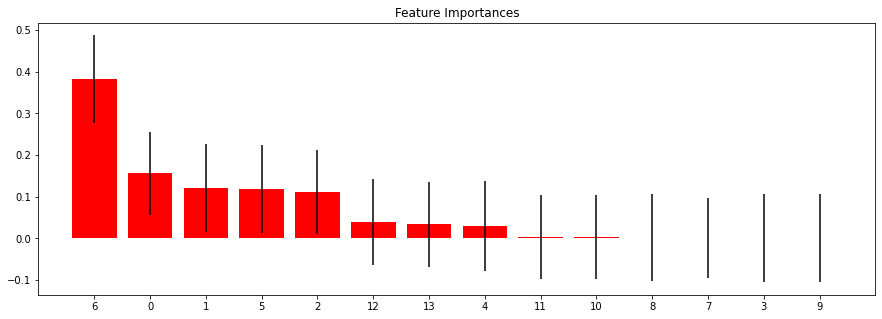

In [34]:
 # model definition - extra trees
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=1)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()

for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15,5))
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

##Machine Learning

In [35]:
cols_selected = ['vintage',
                 'annual_premium',
                 'age',
                 'vehicle_damage_Yes',
                 'policy_sales_channel',
                 'previously_insured',
                 'region_code',
                 'vehicle_age_< 1 Year',
                 'gender_Male']
x_train = df6[cols_selected]
x_val = x_validation[cols_selected]

## KNN Model

In [36]:
x_val.isna().sum()

vintage                 0
annual_premium          0
age                     0
vehicle_damage_Yes      0
policy_sales_channel    0
previously_insured      0
region_code             0
vehicle_age_< 1 Year    0
gender_Male             0
dtype: int64

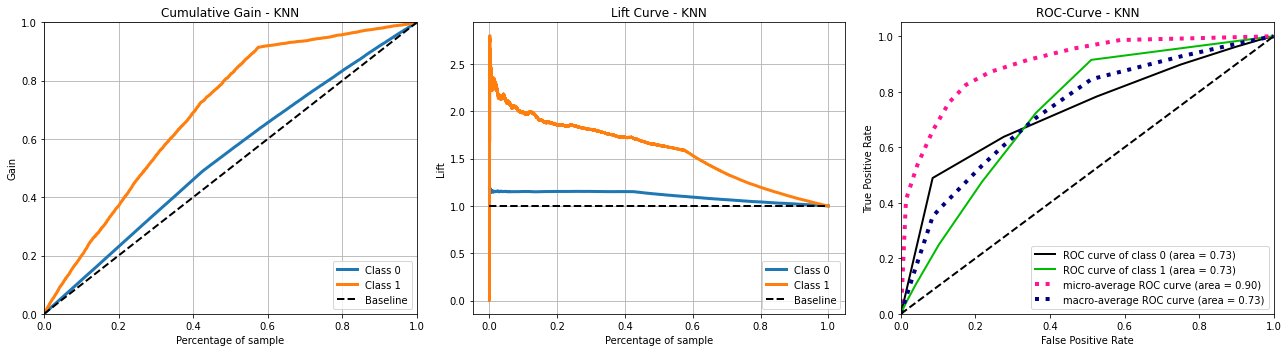

In [37]:
knn = nh.KNeighborsClassifier(n_neighbors=9)
knn.fit(x_train, y_train)
pred_proba_knn = knn.predict_proba(x_val)


fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, pred_proba_knn, ax=axs[0],title='Cumulative Gain - KNN');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, pred_proba_knn,ax=axs[1],title='Lift Curve - KNN');

# Roc Curve
skplt.metrics.plot_roc(y_validation, pred_proba_knn, ax=axs[2], title='ROC-Curve - KNN');

plt.tight_layout()

## Naive Bayes

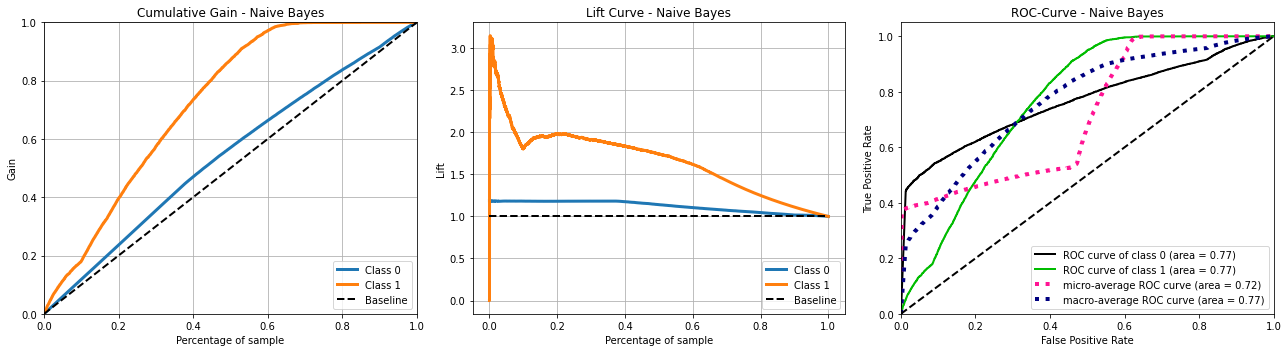

In [38]:
naive = GaussianNB()
naive.fit(x_train, y_train)
pred_proba_naive = naive.predict_proba(x_val)


fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, pred_proba_naive, ax=axs[0],title='Cumulative Gain - Naive Bayes');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, pred_proba_naive,ax=axs[1],title='Lift Curve - Naive Bayes');

# Roc Curve
skplt.metrics.plot_roc(y_validation, pred_proba_naive, ax=axs[2], title='ROC-Curve - Naive Bayes');

plt.tight_layout()

# Model Performance

In [39]:
df7 = df6.copy()

In [40]:
# Copy data
df7_val = x_validation.copy()
df7_val = df7_val[cols_selected]
df7_val['response'] = y_validation.copy()

In [41]:
# dictionary with trained models
models = {'KNN': knn,
          'Naive Bayes': naive,
}

# Calculating Precision and Recall At k = 5,000
k = 5000
model_metrics = {}
for key in models.keys():
    df_scored = prediction_score(models[key], df7_val)
    model_metrics[key] = [df_scored.loc[k, 'precision_at_k'], df_scored.loc[k, 'recall_at_k']]

pd.DataFrame(model_metrics, index=['precision_at_k', 'recall_at_k']).T

,precision_at_k,recall_at_k
KNN,0.305539,0.291770
Naive Bayes,0.309538,0.295589


#Performance on Cross Validation

In [42]:
# Concatenation train and validation dataset to use in cross-validation
df_cv = x_train.copy()
df_cv['response'] = y_train

df_aux = x_val.copy()
df_aux['response'] = y_validation

df_cv = pd.concat([df_cv, df_aux])

# Cross-validated models performance
model_performance = pd.DataFrame()
for key in models.keys():
    performance_cv = cross_validation(5, key, models[key], df_cv, 5000)
    model_performance = pd.concat([model_performance, performance_cv], axis=1)

model_performance.T

,precision_at_k,std_precision,recall_at_k,std_recall
KNN,0.3023,+/-0.0036,0.3591,+/- 0.0043
Naive Bayes,0.315,+/-0.0016,0.3742,+/- 0.0019
